<a href="https://colab.research.google.com/github/gucifer/Brain-Computer-Interface/blob/main/BCI-Deep-Learning-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd drive/My\ Drive/BCICIV_2a_gdf && ls

/bin/bash: line 0: cd: drive/My Drive/BCICIV_2a_gdf: No such file or directory


In [ ]:
!pip install livelossplot

In [ ]:
import collections
from livelossplot import PlotLossesKeras
from scipy.io import loadmat
import numpy as np
import keras
import matplotlib.pyplot as plt#plot the first image in the dataset

Using TensorFlow backend.


In [ ]:
def get_data():
    '''
    Retrieves stored data from Google Drive
    '''
    annots = loadmat('drive/My Drive/matlab.mat')
    x1 = np.array(annots['x1'])
    x2 = np.array(annots['x2'])
    x3 = annots['x3']
    x4 = annots['x4']
    x1_csp = np.array(annots['x1_csp'])
    x2_csp = np.array(annots['x2_csp'])
    x3_csp = annots['x3_csp']
    x4_csp = annots['x4_csp']
    x = np.concatenate((x1[1:,],x2[1:,],x3[1:],x4[1:]))
    y1 = np.zeros([22536,1])
    y2 = np.ones([22536,1])
    y3 = np.ones([22536,1])*2
    y = np.concatenate((y1,y2,y3))
    y = np.concatenate((y,np.ones([22536,1])*3))
    x = np.concatenate((x,y),axis=1)
    return x,y

In [ ]:
def getallsubjects():
    '''
    To be used to combine data of all subjects for subject independent training
    '''
    y_indep = np.concatenate((y_indep,y))
    x_indep = np.concatenate((x_indep,x))
x = x_indep
y = y_indep

NameError: ignored

In [ ]:
 def shuffle(x):
    '''
    Shuffles the data randomly and prints the range of data
    '''
    np.random.shuffle(x)
    y = x[:,25].reshape(x.shape[0],1)
    print(y.shape)
    print(x.shape)
    minval = 1000
    maxval = 0
    for i in x:
        if min(abs(i)) != 0 :
            minval = min(minval,min(abs(i)))
        if max(abs(i)) != 0:
            maxval = max(maxval,max(abs(i)))
    print('Minimum abs value in dataset is',minval)
    print('Maximum abs value in dataset is',maxval)
    return x,y

In [ ]:
from scipy.signal import butter, lfilter

'''
Code for Butterworth Bandpass Filters
'''
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [ ]:
# x_bandpass = butter_bandpass_filter(x[:,:25],8,30,250)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
def scale_data(x_bandpass,trainsplit,testsplit):
    '''
    Scales all data to a similar range to prevent bais
    '''
    x_scaled = x_bandpass[:,:25].copy()
    xtrain_scaled = sc.fit_transform(x_scaled[:trainsplit])
    xtest_scaled = sc.transform(x_scaled[trainsplit:])
    xtrain_scaled = xtrain_scaled.reshape(trainsplit,5,5)
    xtest_scaled = xtest_scaled.reshape(testsplit,5,5)
    return xtrain_scaled,xtest_scaled

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
def lda_data(x_bandpass,y,trainsplit,testsplit):
    '''
    Takes train and test data and train labels and returns data after performing LDA
    '''
    x_lda = x_bandpass[:,:25].copy()
    xtrain_lda = lda.fit_transform(x_lda[:trainsplit],y[:trainsplit])
    xtest_lda = lda.transform(x_lda[trainsplit:])
    xtrain_lda = xtrain_lda.reshape(trainsplit,1,1)
    xtest_lda = xtest_lda.reshape(testsplit,1,1)
    xtrain_lda.shape
    return xtrain_lda,xtest_lda

In [ ]:
def normalize_data(x,data_size):
    '''
    Normalizes input x of size data_size
    '''
    x_normalized = x.copy()
    for i in range(data_size):
        x_normalized[i] = keras.utils.normalize(x_normalized[i])
    return x_normalized

In [ ]:
def reshape_to_image(x,x_bandpass,data_size):
    '''
    Reshapes data into images
    '''
    x = x[:,:25].reshape(data_size,5,5)
    x_bandpass = x_bandpass[:,:25].reshape(data_size,5,5)
    return x, x_bandpass

In [ ]:
def visulize_model1_data():
    '''
    Visualize the diffrence between scaled, normalized and bandpasses data
    '''
    plt.figure()
    plt.imshow(xtrain_scaled[0])
    plt.figure()
    plt.imshow(x_normalized[0])
    plt.figure()
    plt.imshow(x_bandpass[0])

In [ ]:
def reshape_model1_data(x,x_bandpass,xnorm_train,xnorm_test,xscaled_train,xscaled_test,trainsplit,testsplit):
    '''
    Reshapes 2D 80000 x 25 matrices into 80000 x 5 x 5 3D images and stacks them into a 80000 x 3 x 5 x 5
    '''
    print(x.shape)
    X_train = x[:trainsplit].reshape(trainsplit,5,5)
    Xband_train = x_bandpass[:trainsplit].reshape(trainsplit,5,5)
    X_test = x[trainsplit:].reshape(testsplit,5,5)
    Xband_test = x_bandpass[trainsplit:].reshape(testsplit,5,5)
    X_train = np.stack([X_train,xnorm_train,xscaled_train,Xband_train],axis=3)
    X_test = np.stack([X_test,xnorm_test,xscaled_test,Xband_test],axis=3)
    return X_train,X_test

In [ ]:
def plot_final_image(X_train,Y_train,trainsplit):
    '''
    Plots the final image formed by Normalized, Bandpasses and Original Data
    '''
    plt.figure()
    val = np.random.randint(trainsplit-1)
    plt.imshow(X_train[val])
    print(Y_train[val])
    plt.figure()
    val1 = np.random.randint(trainsplit-1)
    plt.imshow(X_train[val1])
    print(Y_train[val1])

In [ ]:
from keras.utils import to_categorical
def prepare_labels(y,trainsplit):
    '''
    Takes the target labels as input and returns categorical matrices as output
    '''
    Y_train = to_categorical(y[:trainsplit])
    Y_test = to_categorical(y[trainsplit:])
    return Y_train,Y_test

In [ ]:
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, DepthwiseConv2D#create model
from sklearn.model_selection import StratifiedKFold
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
def buildmodel1():
    '''
    Compiles and returns a Keras Deep Convolutional Model
    '''
    input1 = keras.layers.Input(shape=(5,5,4))
    input2 = keras.layers.Input(shape=(1,1))
    input1_out = (Conv2D(64, kernel_size= 1,activation='relu'))(input1)
    # input1_out = (BatchNormalization())(input1_out)
    # input1_out = (Dropout(0.25))(input1_out)
    input1_out = (DepthwiseConv2D(kernel_size=1, activation='relu'))(input1_out)
    # input1_out = (BatchNormalization())(input1_out)
    # input1_out = (Dropout(0.25))(input1_out)
    input1_out = (DepthwiseConv2D(kernel_size=1, activation='relu'))(input1_out)
    # input1_out = (BatchNormalization())(input1_out)
    # input1_out = (Dropout(0.25))(input1_out)
    input1_out = (Flatten())(input1_out)
    input1_out = (Dense(256,activation='relu'))(input1_out)
    input1_out = (BatchNormalization())(input1_out)
    input1_out = (Dropout(0.25))(input1_out)
    input1_out = (Dense(64,activation='relu'))(input1_out)
    input1_out = (BatchNormalization())(input1_out)
    input1_out = (Dropout(0.25))(input1_out)
    input1_out = (Dense(32,activation='relu'))(input1_out)
    model1 = Model(input1,input1_out)
    input2_out = (Flatten())(input2)
    input2_out = (BatchNormalization())(input2_out)
    input2_out = (Dropout(0.25))(input2_out)
    input2_out = (Dense(128, activation='relu'))(input2_out)
    input2_out = (BatchNormalization())(input2_out)
    input2_out = (Dropout(0.25))(input2_out)
    input2_out = (Dense(32, activation='relu'))(input2_out)

    model2 = Model(input2,input2_out)
    concatenated = concatenate([input1_out,input2_out])
    # out = (Dense(4, activation='relu'))(concatenated)
    out = (Dense(64, activation='relu'))(concatenated)
    out = (Dense(4, activation='softmax'))(out)
    model = Model([input1,input2],out)
    #HYPERPARAMETER - Learning Rate
    optimizer = keras.optimizers.Adam(lr=0.01)
    #END HYPERPARAMETER
    model.summary()
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def prepare_model1_data():
    '''
    This function is responsible for pre-processing data with respect to the first model.
    Returns the preprocessed training and testing data and labels.
    '''
    #HYPERPARAMETERS - Train-Test Split
    trainsplit = 80000
    testsplit = 10144
    data_size = 90144
    #ENDHYPERPARAMETERS
    x,y = get_data()
    x,y = shuffle(x)
    x_bandpass = butter_bandpass_filter(x[:,:25],8,30,250)
    xtrain_scaled,xtest_scaled = scale_data(x_bandpass,trainsplit,testsplit)
    xtrain_lda,xtest_lda = lda_data(x_bandpass,y,trainsplit,testsplit)
    xtrain_norm = normalize_data(xtrain_scaled,trainsplit)
    xtest_norm = normalize_data(xtest_scaled,testsplit)
    x, x_bandpass = reshape_to_image(x, x_bandpass,data_size)
    X_train,X_test = reshape_model1_data(x,x_bandpass,xtrain_norm,xtest_norm,xtrain_scaled,xtest_scaled,trainsplit,testsplit)
    Y_train,Y_test = prepare_labels(y,trainsplit)
    plot_final_image(X_train,Y_train,trainsplit)
    return X_train,X_test,xtrain_lda,xtest_lda,Y_train,Y_test

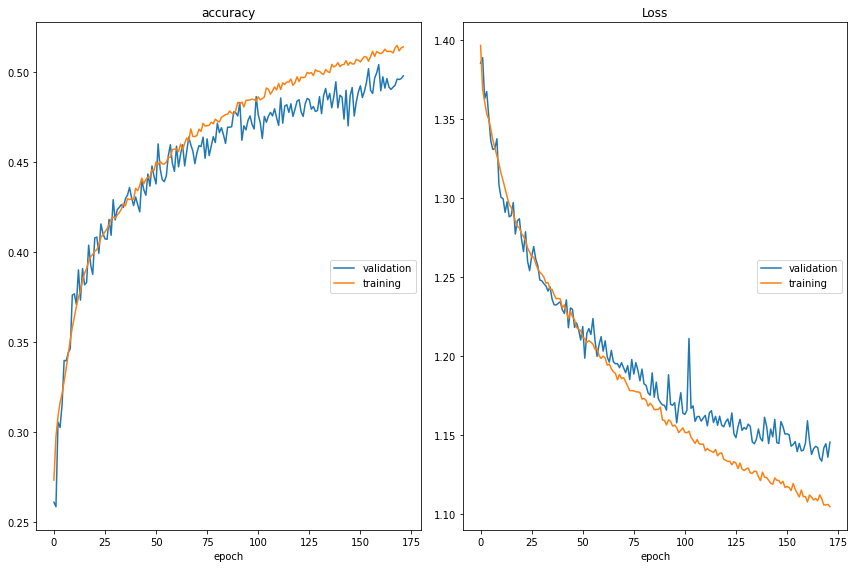

accuracy
	validation       	 (min:    0.259, max:    0.504, cur:    0.498)
	training         	 (min:    0.274, max:    0.515, cur:    0.514)
Loss
	validation       	 (min:    1.134, max:    1.389, cur:    1.146)
	training         	 (min:    1.105, max:    1.397, cur:    1.105)


KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import classification_report
def run_model1():
    X_train,X_test,xtrain_lda,xtest_lda,Y_train,Y_test = prepare_model1_data()
    n_split=10
    model=buildmodel1()
    model.fit([X_train,xtrain_lda], Y_train, epochs=300,callbacks=[PlotLossesKeras()],validation_split=0.05,batch_size=1000,verbose=0)
    print('Model evaluation ',model.evaluate([X_test,xtest_lda],Y_test))
    y_pred = model.predict([X_test,xtest_lda])
    y_pred = (y_pred > 0.5) 
    print(classification_report(Y_test, y_pred))
run_model1()

In [ ]:
subject1: 50.65%
subject2: 47.42%
subject3: 44.68%
subject4: 47.96%
subject5: 59.4%
subject6: 47.94%
subject7: 55.4%
subject8: 54.99%
subject9: 56.75%
avg: 51.687%

In [ ]:
!pip install mne

     |████████████████████████████████| 6.6MB 5.5MB/s 


In [ ]:
import mne.decoding as mne

In [ ]:
sample_instance = mne.CSP(2)
'''
Get Filtered Data
'''
#HYPERPARAMETERS - Train-Test Split
trainsplit = 80000
testsplit = 10144
data_size = 90144
#ENDHYPERPARAMETERS
x,y = get_data()
x_transpose = np.vsplit(x[:,:25],288)
x_csp = []
for i in x_transpose:
    x_csp.append(np.transpose(i))
x_csp = np.asarray(x_csp)
y1 = np.zeros([72,1])
y2 = np.ones([72,1])
y3 = np.ones([72,1])
y_csp = np.concatenate((y1,y2,y3))
y_csp = np.concatenate((y_csp,np.ones([72,1])))
x_csp[y_csp == 0]

IndexError: ignored

In [ ]:
sample_instance.fit(x_csp,y_csp)

IndexError: ignored

In [ ]:
22536/313

72.0